In [1]:
# Loading the libraries

import h5py
import numpy as np
import pandas as pd
import os
import pandas as pd
import seaborn as sn
import torch
import torchvision.models as models
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from IPython.core.display import display
from collections.abc import Mapping
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
import torchmetrics
from torchvision.transforms import ToTensor
import astropy.units as u
import astropy.coordinates as coord

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-colorblind')

/tmp/ipykernel_57907/383724796.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [15]:
# Choose the training parameters
sim = 'DR3_lsr012' #input("DR2 or DR3: ")
dim = '5D' #input("Input how many dimensions are needed: ")
galaxy = 'Gaia' #input("Use m12i or m12f data: ")
transfer = True #bool(input("Transfer learning (True or False): "))
if transfer == True:
    transfer_galaxy = 'm12i' #i nput("Which galaxy parameters for transfer learning: ")

# Training data
if dim == '4D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec']
elif dim == '5D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax']
elif dim == '6D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity']
elif dim == '7D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity', 'feh']
elif dim == '9D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity', 'Jr', 'Jphi', 'Jz']
elif dim == '10D':
    x_keys = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity', 'Jr', 'Jphi', 'Jz', 'feh']
elif dim == '6D_cyl':
    x_keys = ['x_gal', 'y_gal', 'z_gal', 'vx_gal', 'vy_gal', 'vz_gal']
elif dim == '6D_gal':
    x_keys = ['rho_cyl', 'phi_cyl', 'z_cyl', 'vrho_cyl', 'vphi_cyl', 'vz_cyl']
    
y_key = 'is_accreted'

# Directories
# path = '/ocean/projects/phy210068p/hsu1/Ananke_datasets_training/AnankeDR3_data_reduced_m12i_lsr012.hdf5'
path = '/ocean/projects/phy210068p/hsu1/Ananke_datasets_training/GaiaDR3_data_reduced_feh.hdf5'

out_dir = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim + '/' + galaxy + '/' + dim
roc_title = sim + '_' + galaxy + '_' + dim

# Parameters
learning_rate = 1e-3
batch_size = 1024
roc_path = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim + '/' + galaxy + '/roc_parameters.hdf5'
training_score_path = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim + '/' + galaxy + '/' + dim + '/training_score.hdf5'

if transfer == True:
    transfer_checkpoint = '/ocean/projects/phy210068p/hsu1/Training_results/' + sim +'/'+ transfer_galaxy +'/'+ dim + '/training_logs/version_0/checkpoints/last.ckpt'

train_parameter_file = out_dir + '/training_parameters.hdf5'
train_log = out_dir + '/training_logs'
checkpoint = train_log + '/version_0/checkpoints/last.ckpt'

In [16]:
# Loading data
data = []
f = h5py.File(path, 'r')

for i in x_keys:
    data.append(f[i][:])
y = f[y_key][:]

# Getting rid of nan values
x = []
if 'Jr' in x_keys:
    Jr = f['Jr'][:]
    mask = (~np.isnan(Jr))
    for i in range(len(x_keys)):
        new = data[i][:][mask]
        x.append(new)
    y = y[mask]
elif 'radial_velocity' in x_keys:
    rv = f['radial_velocity'][:]
    mask = (~np.isnan(rv))
    for i in range(len(x_keys)):
        new = data[i][:][mask]
        x.append(new)
    y = y[mask]
else:
    x = data

x = np.vstack(x).T
f.close()

In [17]:
# Process the data and make it into a tensor

mean_x = np.mean(x, axis = 0)
stdv_x = np.std(x, axis = 0)
catalog_x = (x - mean_x) / stdv_x
catalog_x = torch.tensor(catalog_x, dtype=torch.float32)
catalog_y = torch.tensor(y, dtype=torch.long)

catalog_dataset = TensorDataset(catalog_x, catalog_y)
catalog_loader = DataLoader(catalog_dataset, batch_size = batch_size)

In [18]:
# Lightning model used in training
class Model(LightningModule):
                
    def __init__(self, weight, mean_train_x, stdv_train_x, transfer):
        super().__init__()
        self.save_hyperparameters()
        self.l1 = torch.nn.Linear(len(x_keys), 100) 
        self.l2 = torch.nn.Linear(100, 50)
        self.l3 = torch.nn.Linear(50, 2)
        
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.weight = weight
        self.mean_train_x = mean_train_x
        self.stdv_train_x = stdv_train_x
        if transfer == True:
            self.feature_extractor = Model.load_from_checkpoint(transfer_checkpoint, transfer=False)
            self.feature_extractor.freeze()
    
    def forward(self, x):
        x_out = self.l1(x)
        x_out = torch.relu(x_out)
        x_out = self.l2(x_out)
        x_out = torch.relu(x_out)
        x_out = self.l3(x_out)
        return x_out
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)
    
    def training_step(self, batch, batch_nb):
        train_x, train_y = batch 
        preds = self(train_x)
        loss = F.cross_entropy(preds, train_y, weight = self.weight.to(self.device))
        self.train_acc(preds, train_y)
        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_nb):
        val_x, val_y = batch
        preds = self(val_x)
        loss = F.cross_entropy(preds, val_y, weight=self.weight.to(self.device))
        self.valid_acc(preds, val_y)
        self.log('val_loss', loss)
        self.log('valid_acc', self.valid_acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

In [19]:
# Load the model that has already been trained

model = Model.load_from_checkpoint(checkpoint)

In [20]:
# Evaluate the model
predict = []
# target = []
# x_final = []

model.eval()
with torch.no_grad():
    for batch in catalog_loader:
        x, y = batch
        yhat = model(x)
        predict.append(yhat.cpu().numpy())
        # target.append(y.cpu().numpy())
        # x_final.append(x.cpu().numpy())

# x_final = np.concatenate(x_final)

: 

: 

In [ ]:
# Concatenate the predictions
predict = np.concatenate(predict)

In [ ]:
# Calculate the scores
score = np.exp(predict[:,1])/(np.exp(predict[:,0])+np.exp(predict[:,1]))

/tmp/ipykernel_90050/2079031010.py:1: RuntimeWarning: overflow encountered in exp
  score = np.exp(predict[:,1])/(np.exp(predict[:,0])+np.exp(predict[:,1]))


In [78]:
# Splitting the score into labels based on a score cut of 0.7623
mask0 = (score < 0.7623)
mask1 = (score > 0.7623)
np.sum(mask0), np.sum(mask1)

(23535696, 535366)

Below is for loading back the scores already calculated.


In [2]:
path = '/ocean/projects/phy210068p/hsu1/Ananke_datasets_training/GaiaDR3_data_reduced_feh.hdf5'
with h5py.File(path, 'r') as f:
    score = f['score_6D'][:]
    ra = f['ra'][:]
    dec = f['dec'][:]
    pmra = f['pmra'][:]
    pmdec = f['pmdec'][:]
    parallax = f['parallax'][:]
    rv = f['radial_velocity'][:]
    feh = f['feh'][:]
    
    # f.create_dataset('score_6D', data=score)

In [3]:
ra.shape, score.shape, np.sum(~np.isnan(rv))

((90172126,), (24071062,), 24071062)

In [4]:
mask = ~np.isnan(rv)
ra = ra[mask]
dec = dec[mask]
pmra = pmra[mask]
pmdec = pmdec[mask]
parallax = parallax[mask]
rv = rv[mask]
feh = feh[mask]

In [5]:
ra = ra * u.deg
dec = dec * u.deg
pmra = pmra * u.mas / u.yr
pmdec = pmdec * u.mas / u.yr
parallax = parallax * u.mas
rv = rv * u.km / u.s

dist = coord.Distance(parallax=parallax, allow_negative=True)

# Coord transformation to galactocentric and cylindrical 
icrs = coord.ICRS(
    ra=ra, dec=dec, distance=dist, pm_ra_cosdec=pmra, pm_dec=pmdec, radial_velocity=rv)
gal = icrs.transform_to(coord.Galactocentric())
x_gal = gal.x.to_value(u.kpc)
y_gal = gal.y.to_value(u.kpc)
z_gal = gal.z.to_value(u.kpc)
vx_gal = gal.v_x.to_value(u.km/u.s)
vy_gal = gal.v_y.to_value(u.km/u.s)
vz_gal = gal.v_z.to_value(u.km/u.s)  

In [6]:
mask0 = (score < 0.7623)
mask1 = (score > 0.7623)
vx0 = vx_gal[mask0]
vy0 = vy_gal[mask0]
vz0 = vz_gal[mask0]
vx1 = vx_gal[mask1]
vy1 = vy_gal[mask1]
vz1 = vz_gal[mask1]
z0 = z_gal[mask0]
z1 = z_gal[mask1]
feh0 = feh[mask0]
feh1 = feh[mask1]

vr0 = np.sqrt(vx0**2 + vz0**2)
vr1 = np.sqrt(vx1**2 + vz1**2)

In [10]:
len(vr0), len(vr1), len(vr1)/len(vr0)

(23535696, 535366, 0.022746979736651934)

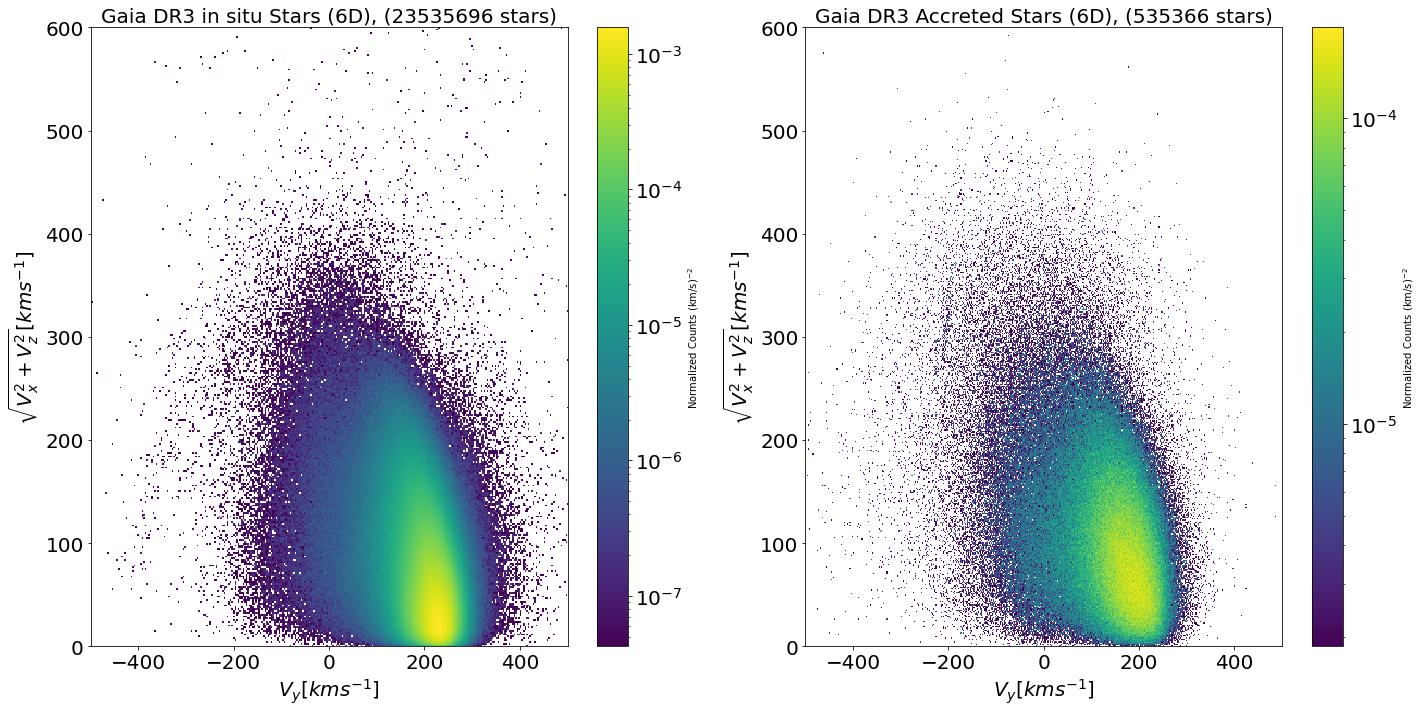

In [8]:
# Plot the Toomre diagrams for accreted and in situ stars based on ZM cuts
# Plot z and feh distributions for accreted and in situ stars based on ZM cuts
fig, ax = plt.subplots(1,2, figsize=(20, 10))

h = ax[0].hist2d(vy0, vr0, bins=500, weights=np.repeat(1/len(vx0), len(vx0)), norm=mpl.colors.LogNorm()) #vmin=10e-8, vmax=10e-3
ax[0].set_xlabel(r'$V_y [km s^{-1}]$', fontsize=20)
ax[0].set_ylabel(r'$\sqrt{V_x^2+V_z^2} [km s^{-1}]$', fontsize=20)
ax[0].set_title(f'Gaia DR3 in situ Stars (6D), ({len(vy0)} stars)', fontsize=20)
ax[0].set_xlim([-500, 500])
ax[0].set_ylim([0, 600])
cb = fig.colorbar(h[3], ax=ax[0], label=r'Normalized Counts (km/s)$^{-2}$') 
cb.ax.tick_params(labelsize=20)
ax[0].tick_params(axis='both', labelsize=20)


h = ax[1].hist2d(vy1, vr1, bins=500, weights=np.repeat(1/len(vx1), len(vx1)), norm=mpl.colors.LogNorm())
ax[1].set_xlabel(r'$V_y [km s^{-1}]$', fontsize=20)
ax[1].set_ylabel(r'$\sqrt{V_x^2+V_z^2} [km s^{-1}]$', fontsize=20)
ax[1].set_title(f'Gaia DR3 Accreted Stars (6D), ({len(vy1)} stars)', fontsize=20)
ax[1].set_xlim([-500, 500])
ax[1].set_ylim([0, 600])
cb = fig.colorbar(h[3], ax=ax[1], label=r'Normalized Counts (km/s)$^{-2}$') 
cb.ax.tick_params(labelsize=20)
ax[1].tick_params(axis='both', labelsize=20)

plt.tight_layout()
plt.show()

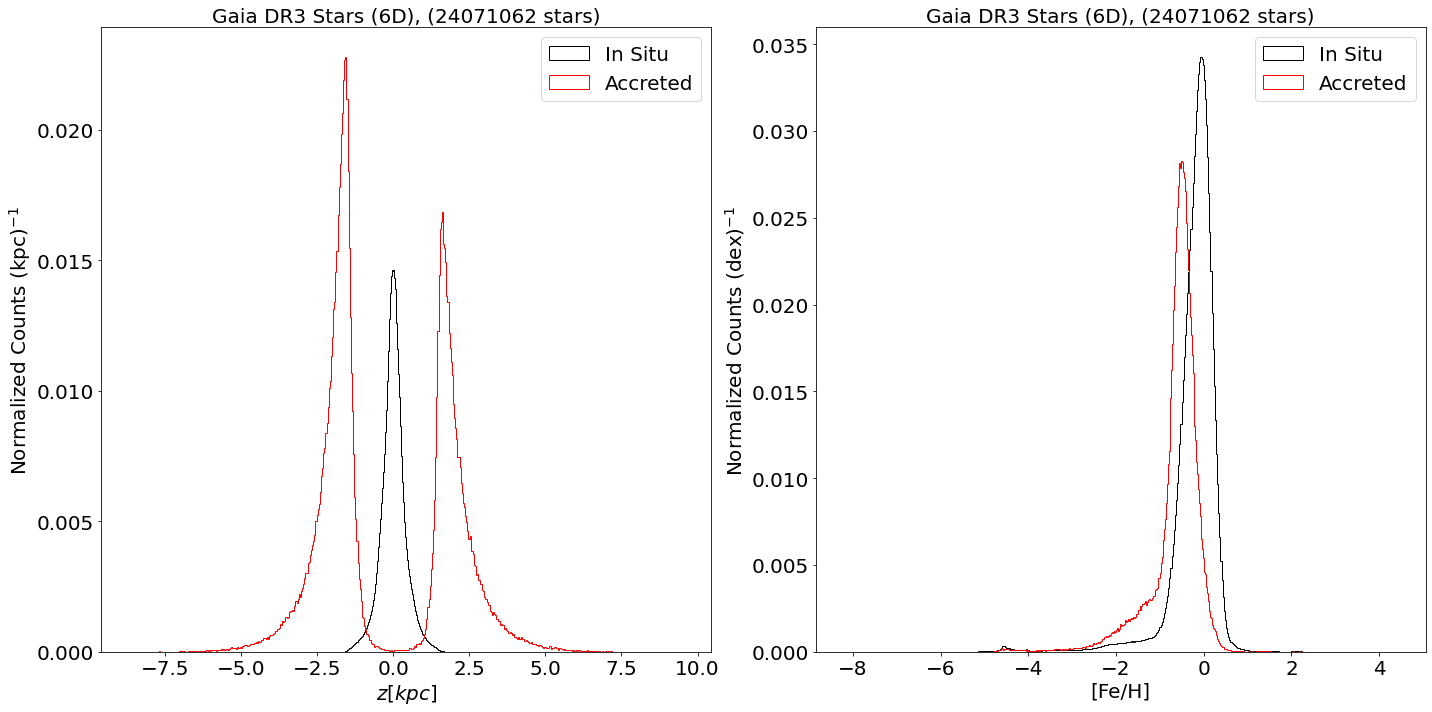

In [9]:
# Plot the Toomre diagrams for accreted and in situ stars based on ZM cuts
# Plot z and feh distributions for accreted and in situ stars based on ZM cuts
fig, ax = plt.subplots(1,2, figsize=(20, 10))

ax[0].hist(z0, bins=500, weights=np.repeat(1/len(z0), len(z0)), histtype='step', color='k', label='In Situ')
ax[0].hist(z1, bins=500, weights=np.repeat(1/len(z1), len(z1)), histtype='step', color='r', label='Accreted')
ax[0].set_xlabel(r'$z [kpc]$', fontsize=20)
ax[0].set_ylabel(r'Normalized Counts (kpc)$^{-1}$', fontsize=20)
ax[0].set_title(f'Gaia DR3 Stars (6D), ({len(z0)+len(z1)} stars)', fontsize=20)
# ax[0].set_xlim([-10, 10])
# ax[0].set_ylim([0, 0.5])
ax[0].tick_params(axis='both', labelsize=20)
ax[0].legend(fontsize=20)

ax[1].hist(feh0, bins=500, weights=np.repeat(1/len(feh0), len(feh0)), histtype='step', color='k', label='In Situ')
ax[1].hist(feh1, bins=500, weights=np.repeat(1/len(feh1), len(feh1)), histtype='step', color='r', label='Accreted')
ax[1].set_xlabel(r'[Fe/H]', fontsize=20)
ax[1].set_ylabel(r'Normalized Counts (dex)$^{-1}$', fontsize=20)
ax[1].set_title(f'Gaia DR3 Stars (6D), ({len(feh0)+len(feh1)} stars)', fontsize=20)
# ax[1].set_xlim([-3, 1])
# ax[1].set_ylim([0, 0.5])
ax[1].tick_params(axis='both', labelsize=20)
ax[1].legend(fontsize=20)

plt.tight_layout()
plt.legend(fontsize=20)
plt.show()